In [1]:
import sys, pickle
sys.path.append('../src')
import numpy as np
from scipy.linalg import svd
from scipy.stats import permutation_test, wilcoxon
from tqdm import tqdm
import matplotlib.pyplot as plt
from utils import *
from helper_funcs import *
from visualization import plot_mean_std
rng = np.random.default_rng()

In [2]:
XS_PERT = np.linspace(0, 1, num=6)

In [3]:
rate_onm, rate_offm = [], []
# correlations between disrupted J and syllables for the four disruption cases
corr_ctrl, corr_disr = [], []
svds = []

for i in tqdm(range(1,11)):
    with open('../results/EIrec_J_disrupt_exp%s.pkl' % i, 'rb') as f:
        res = pickle.load(f)
    
    # syl is directly derived from the input data, so all are the same
    syl = res['syl'] 
    NE = syl.shape[1]
    
    rate_onm += res['on_manifold']
    rate_offm += res['off_manifold']

    svds.append(res['svds'])
    J = svds[-1][-1][0] @ np.diag(svds[-1][-1][1]) @ svds[-1][-1][2]
    corr_ctrl.append(correlation(J[:NE,:NE], syl, dim=2))
    corr_disr.extend(res['J_disr_corrs'])
    
print(res['order'])
n_case = len(res['order'])
n_shuffle = len(res['on_manifold'])

# (simulations, cases, pert values, NE)
rate_onm, rate_offm = np.stack(rate_onm), np.stack(rate_offm)
# (simulations * cases, NE, syllable)
corr_ctrl, corr_disr = np.stack(corr_ctrl), np.stack(corr_disr)

100%|███████████████████████████████████████████| 10/10 [00:06<00:00,  1.64it/s]

['original', 'memory', 'landscape', 'rand']


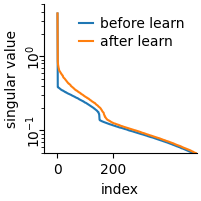

In [4]:
fig, ax = plt.subplots(1, figsize=(2, 2))
ax.plot(svds[0][0][1], label='before learn')
ax.plot(svds[0][-1][1], label='after learn')
ax.legend()
ax.set(yscale='log', ylim=[5e-2, 5], xlim=[-50, 500], xticks=[0, 200],
       ylabel='singular value', xlabel='index')
ax.set_yticks([1e-1, 1], labels=['$10^{-1}$', '$10^0$'], 
              ha='center', va='center', rotation=90)
fig.savefig('../svg/log_singular_value.svg')

[2 3 5 8] [ 2  3  4  5  6  8 10]


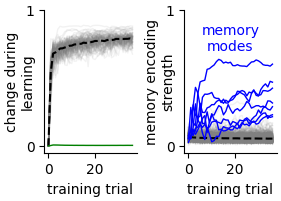

In [5]:
change, i_outlier, i_nonout = characterize_change(svds[1])
mem_enc, i_memory, i_nonmem = characterize_memory(svds[1], syl, 'left')

print(i_outlier + 1, i_memory + 1)

fig, ax = plt.subplots(1, 2, figsize=(2.8,2))

ax[0].plot(change, c='grey', alpha=0.1, lw=1, zorder=-1)
ax[0].plot(change[:,1:].mean(axis=1), c='k', ls='--', zorder=1)
ax[0].plot(change[:,0], c='g', lw=1, zorder=2)
ax[0].set(yticks=[0, 1], ylim=[-0.05, 1])
ax[0].set_ylabel('change during\nlearning', va='center')
ax[0].set_xlabel('training trial', va='top')
ax[1].set_rasterization_zorder(0)

ax[1].plot(mem_enc[:,i_nonmem], c='grey', alpha=0.1, lw=1, zorder=-1)
ax[1].plot(mem_enc[:,i_nonmem].mean(axis=1), c='k', ls='--', zorder=1)
ax[1].plot(mem_enc[:,i_memory], c='b', lw=1, alpha=1, zorder=1)
ax[1].text(change.shape[0]//2, 0.7, 'memory\nmodes', ha='center', c='b')
ax[1].set(ylim=[-0.05, 1], yticks=[0, 1])
ax[1].set_ylabel('memory encoding\nstrength', va='center')
ax[1].set_xlabel('training trial', va='top')
ax[1].set_rasterization_zorder(0)

fig.savefig('../svg/mode_learning_curves_E2I2E.svg')

In [6]:
def get_timeconst(x):
    xmin, xmax = x.min(axis=0), x.max(axis=0)
    x = (x - xmin) / (xmax - xmin)
    return np.where(x > 1 - 5**(-1))[0][0]

tc_landscape, tc_memory = [], []
for i in range(len(svds)):
    change = characterize_change(svds[i])[0]
    mem_enc, i_memory, i_nonmem = characterize_memory(svds[i], syl, 'left')
    i_landscape = i_nonmem[1:10] 
    tc_landscape.append(get_timeconst(change[:,i_landscape].mean(axis=1)))
    tc_memory.append(get_timeconst(mem_enc[:,i_memory].mean(axis=1)))

0.0009765625


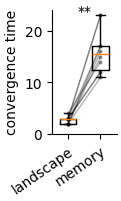

In [7]:
fig, ax = plt.subplots(1, figsize=(1.2,2))
for x, y in zip(tc_landscape, tc_memory):
    ax.plot([1, 2], [x, y], '-o', c='k', alpha=0.3, ms=2, lw=1)
ax.boxplot([tc_landscape, tc_memory], widths=[0.5, 0.5])
pval = wilcoxon(tc_landscape, tc_memory, alternative='less').pvalue
print(pval)
if pval < 0.05:
    ax.text(1.5, np.max(tc_memory), '**' if pval < 0.01 else '*', ha='center')
else:
    ax.text(1.5, np.max(tc_memory), 'ns', ha='center', va='bottom')
ax.set(ylim=[0, ax.get_ylim()[1]], ylabel='convergence time')
ax.set_xticklabels(['landscape', 'memory'], rotation=35, ha='right', rotation_mode='anchor')
fig.savefig('../svg/mode_time_constants.svg')

In [44]:
case_names = ['original', 'without memory modes', 'without 10 landscape modes', 
              'without 10 random modes']
case_colors = ['k', 'b', 'r', 'purple']

1.3255618041383154e-17
0.02249793904743314
0.37014777991649084


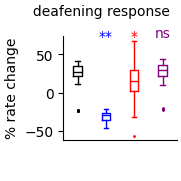

In [57]:
fig, ax = plt.subplots(1, figsize=(1.8,1.8))

m = rate_onm.mean(axis=-1)
m = (m / m[...,0,None] - 1) * 100

for i, c in enumerate(case_colors):
    ax.boxplot(m[:,i,1], positions=[i], 
               widths=0.3, flierprops=dict(ms=2, mec=c), 
               boxprops=dict(color=c), capprops=dict(color=c),
               whiskerprops=dict(color=c), medianprops=dict(color=c))
for i, c in enumerate(case_colors):
    x, y = (i+1) / (n_case+1), ax.get_ylim()[1] - 5
    # pval = wilcoxon(m[:,i,1]).pvalue
    if i > 0:
        pval = ranksums(m[:,0,1], m[:,i,1]).pvalue
        print(pval)
        if pval < 0.05:
            ax.text(i, m.max(), '**' if pval < 0.01 else '*', ha='center', c=c)
        else:
            ax.text(i, m.max(), 'ns', ha='center', va='bottom', c=c)
ax.set(ylabel='% rate change', xticks=[], xlabel=' \n')
fig.suptitle(' '*5+'deafening response', fontsize=10)
fig.savefig('../svg/on_manifold_perturb.svg')

7.44388828444204e-14
7.134570801061701e-10
0.7933483063526747


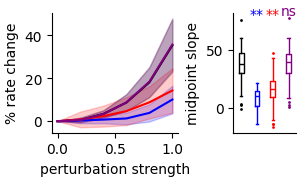

In [56]:
from scipy.stats import ranksums
fig, ax = plt.subplots(1, 2, figsize=(3,1.8), width_ratios=[1,0.5])

m = rate_offm.mean(axis=-1)
m = (m / m[...,0,None] - 1) * 100
g = np.gradient(m, XS_PERT, axis=-1)[...,3]

for i, c in enumerate(case_colors):
    plot_mean_std(ax[0], m[:,i].mean(axis=0), m[:,i].std(axis=0), 
                  a_fill=0.2, c=c, xs=XS_PERT)
    ax[1].boxplot(g[:,i], positions=[i], 
                  widths=0.3, flierprops=dict(ms=2, mec=c), 
                  boxprops=dict(color=c), capprops=dict(color=c),
                  whiskerprops=dict(color=c), medianprops=dict(color=c))
    if i > 0:
        pval = ranksums(g[:,0], g[:,i]).pvalue
        print(pval)
        if pval < 0.05:
            ax[1].text(i, g.max(), '**' if pval < 0.01 else '*', ha='center', c=c)
        else:
            ax[1].text(i, g.max(), 'ns', ha='center', va='bottom', c=c)
ax[0].set(xlabel='perturbation strength', ylabel='% rate change')
ax[1].set(xticks=[], ylabel='midpoint slope')
fig.savefig('../svg/off_manifold_perturb.svg')

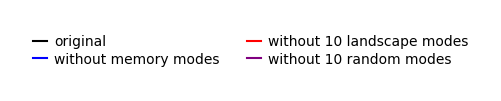

In [47]:
fig, ax = plt.subplots(1, figsize=(5,1))
for n, c in zip(case_names, case_colors):
    ax.plot(0, 0, c=c, label=n)
ax.set_axis_off()
ax.legend(loc='center', ncols=2, columnspacing=2)
fig.savefig('../svg/dummy_label_EIrec_analysis.svg')

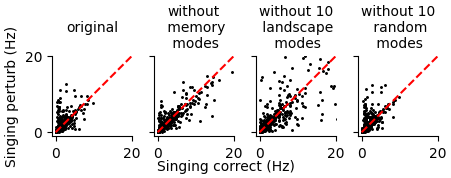

In [48]:
fig, ax = plt.subplots(1, n_case, sharex='all', sharey='all', figsize=(4.5, 2))
l = 0
i_ctrl = 0 # index of singing correct
i_pert = 4 # index of singing perturb
for i, k in enumerate(case_names):
    z_ctrl = rate_offm[0,i,i_ctrl]
    z_pert = rate_offm[0,i,i_pert]
    ax[i].scatter(z_ctrl, z_pert, c='k', s=5)
    ax[i].plot([0,50], [0,50], c='r', ls='--')
    k = k.split(' ')
    k[len(k)//4] = k[len(k)//4] + '\n'
    if len(k) > 1:
        k[-2] = k[-2] + '\n'
    k = ' '.join(k)
    ax[i].set(aspect=1, title=k, xlim=[-1,20], ylim=[-1,20])
ax[0].set(ylabel='Singing perturb (Hz)', xlabel='\n')
fig.text(0.5, 0.15, 'Singing correct (Hz)', ha='center', va='center')
fig.savefig('../svg/joint_dist_J_disrupt_pert.svg')

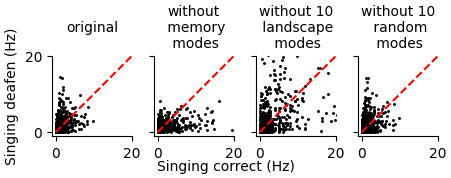

In [49]:
fig, ax = plt.subplots(1, n_case, sharex='all', sharey='all', figsize=(4.5, 2))
l = 0
i_ctrl = 0 # index of singing correct
i_pert = 1 # index of singing perturb
for i, k in enumerate(case_names):
    z_ctrl = rate_offm[0,i,i_ctrl]
    z_pert = rate_onm[0,i,i_pert]
    ax[i].scatter(z_ctrl, z_pert, c='k', s=5)
    ax[i].plot([0,50], [0,50], c='r', ls='--')
    k = k.split(' ')
    k[len(k)//4] = k[len(k)//4] + '\n'
    if len(k) > 1:
        k[-2] = k[-2] + '\n'
    k = ' '.join(k)
    ax[i].set(aspect=1, title=k, xlim=[-1,20], ylim=[-1,20])
ax[0].set(ylabel='Singing deafen (Hz)', xlabel='\n')
fig.text(0.5, 0.15, 'Singing correct (Hz)', ha='center', va='center')
fig.savefig('../svg/joint_dist_J_disrupt_deafen.svg')